In [42]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

In [43]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from mlp_sparse_model import MLPSparseModel
from mlp_plain_model import MLPPlainModel
import time

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.7f}".format

# The following line improves formatting when ouputting NumPy arrays.
np.set_printoptions(linewidth = 200)

SAMPLE_SIZE = 11
N_EXP = 20

In [44]:
def seed_generator():
    # Generate the initial seed for each sample size (to match the seed
    # of the results in the paper)
    # This is just the initial seed, for each experiment, the seeds will be
    # equal the initial seed + the number of the experiment

    N_train_all = np.multiply(11, [1, 2, 3, 4, 5])  # This is for LLVM
    if SAMPLE_SIZE in N_train_all:
        seed_o = np.where(N_train_all == SAMPLE_SIZE)[0][0]
    else:
        seed_o = np.random.randint(1, 101)

    return seed_o

In [45]:
#@title Get data
data_df = pd.read_csv("Data/LLVM_AllNumeric.csv")
column_dict = {name: bool for name in list(data_df.columns.values) if name != 'PERF'}
column_dict['PERF'] = "float64"
data_df = data_df.astype(column_dict)
data_df = data_df.reindex(np.random.permutation(data_df.index))

In [46]:
# Normalize values
data_df_mean = data_df.mean()
data_df_std = data_df.std()
data_df_norm = (data_df - data_df_mean)/data_df_std

In [47]:
# split data set and set seed
seed_init = seed_generator()
seed = seed_init*N_EXP + 1
np.random.seed(seed_init)
train_df = data_df_norm.sample(frac=0.6)
test_df = data_df_norm.drop(train_df.index).sample(frac=1.0)

In [48]:
# create feature layer
columns = [column for column in column_dict.keys() if column != 'PERF']
feature_columns = []
for column in columns:
    feature_columns.append(tf.feature_column.numeric_column(column))
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [49]:
#@title Define the plotting function.

def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()

In [63]:
#@title Double-click for a possible solution

# The following "solution" uses L2 regularization to bring training loss
# and test loss closer to each other. Many, many other solutions are possible.


def create_model(learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""

  # Discard any pre-existing version of the model.
  model = None

  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Describe the topography of the model. 

  # Implement L2 regularization in the first hidden layer.
  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l1(0.007),
                                  name='Hidden1'))
  
  # Implement L2 regularization in the second hidden layer.
  model.add(tf.keras.layers.Dense(units=12, 
                                  activation='relu', 
                                  kernel_regularizer=tf.keras.regularizers.l1(0.007),
                                  name='Hidden2'))

  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model     


In [51]:
def train_model(model, dataset, epochs, label_name,
                batch_size=None, validation_split=0.1):
  """Train the model by feeding it data."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, validation_split=validation_split) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


56/56 [==============================] - 1s 8ms/step - loss: 0.7603 - mean_squared_error: 0.6651 - val_loss: 0.3532 - val_mean_squared_error: 0.2582
Epoch 2/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2889 - mean_squared_error: 0.1956 - val_loss: 0.2279 - val_mean_squared_error: 0.1367
Epoch 3/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2113 - mean_squared_error: 0.1223 - val_loss: 0.1851 - val_mean_squared_error: 0.0989
Epoch 4/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1713 - mean_squared_error: 0.0876 - val_loss: 0.1653 - val_mean_squared_error: 0.0839
Epoch 5/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1577 - mean_squared_error: 0.0787 - val_loss: 0.1511 - val_mean_squared_error: 0.0746
Epoch 6/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1436 - mean_squared_error: 0.0687 - val_loss: 0.1553 - val_mean_squared_error: 0.0825
Epoch 7/100
56/56 [===========================

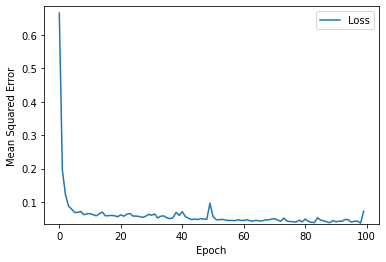


 Evaluate the new model against the test set:
41/41 [==============================] - 0s 3ms/step - loss: 0.0815 - mean_squared_error: 0.0524


[0.08154114335775375, 0.05242207646369934]

In [62]:
# The following variables are the hyperparameters.
learning_rate = 0.007
epochs = 100
batch_size = 10

label_name = "PERF"

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model, train_df, epochs, 
                          label_name, batch_size, validation_split=0.1)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size) 